## DC2 Bootstrap Testing

In [1]:
import torch
import numpy as np
from os import environ
from pathlib import Path
from einops import rearrange
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from hydra import initialize, compose
from hydra.utils import instantiate

from bliss.surveys.dc2 import DC2
from pathlib import Path

from bliss.catalog import FullCatalog, TileCatalog
from torch.utils.data import RandomSampler, DataLoader

from torchmetrics import MetricCollection
from torch.nn.utils.rnn import pad_sequence
import tqdm
from pytorch_lightning.utilities import move_data_to_device

environ["BLISS_HOME"] = str(Path().resolve().parents[1])

output_dir = Path("./DC2_bootstrap_output/")
output_dir.mkdir(parents=True, exist_ok=True)

In [2]:
with initialize(config_path=".", version_base=None):
    notebook_cfg = compose("notebook_config")

In [3]:
dc2: DC2 = instantiate(notebook_cfg.surveys.dc2)
dc2.prepare_data()
dc2.setup()
dc2_test_dataset = dc2.test_dataset
dc2_image_height = dc2_test_dataset[0]["images"].shape[1]
dc2_image_width = dc2_test_dataset[0]["images"].shape[2]
dc2_test_bs_loader = DataLoader(dc2_test_dataset, 
                                sampler=RandomSampler(dc2_test_dataset, replacement=True),
                                batch_size=64,
                                num_workers=0)

In [4]:
def get_lsst_output(batch, lsst_split_results_dir, r_band_min_flux, device):
    image_lim = batch["images"].shape[2]
    assert batch["images"].shape[2] == batch["images"].shape[3], \
            "image width should be equal to image height"
    plocs_list = []
    source_type_list = []
    flux_list = []
    n_sources = []

    for split_id in batch["split_id"]:
        with open(lsst_split_results_dir / ("lsst_" + split_id), "rb") as split_result_file:
            split_result = torch.load(split_result_file)
        cur_plocs, cur_source_type, cur_flux = split_result["plocs"], split_result["source_type"], split_result["flux"]

        flux_mask = cur_flux[:, 2] > r_band_min_flux
        cur_plocs = cur_plocs[flux_mask, :]
        cur_source_type = cur_source_type[flux_mask]
        cur_flux = cur_flux[flux_mask, :]
     
        plocs_list.append(cur_plocs)
        source_type_list.append(cur_source_type)
        n_sources.append(cur_plocs.shape[0])
        flux_list.append(cur_flux)

    plocs = pad_sequence(plocs_list, batch_first=True)
    source_type = pad_sequence(source_type_list, batch_first=True)
    n_sources = torch.tensor(n_sources)
    flux = pad_sequence(flux_list, batch_first=True)

    return FullCatalog(height=image_lim, width=image_lim, d={
        "plocs": plocs.to(device=device),
        "n_sources": n_sources.to(device=device),
        "source_type": source_type.to(device=device),
        "galaxy_fluxes": flux.to(device=device),
        "star_fluxes": flux.clone().to(device=device),
    })

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# change the model path before running this code
# please also check the config in notebook_config.yaml to ensure the encoder's config
# is the same as your model config
MODEL_PATH = "../../output/DC2_experiments/DC2_psf_aug_asinh_05-27-1/checkpoints/best_encoder.ckpt"
encoder = instantiate(notebook_cfg.encoder)
pretrained_weights = torch.load(MODEL_PATH)["state_dict"]
encoder.load_state_dict(pretrained_weights)
encoder.to(device=device)
encoder.eval();

In [7]:
# could use macher for bliss catalog and truth catalog
# this function (match_by_locs) is for matching the lsst detection location and truth object location
from einops import rearrange, reduce
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import min_weight_full_bipartite_matching
def match_by_locs(true_cat, est_cat, slack=1.0):
    true_locs, est_locs = true_cat["plocs"], est_cat["plocs"]
    assert len(true_locs.shape) == len(est_locs.shape) == 3
    assert true_locs.shape[-1] == est_locs.shape[-1] == 2
    assert true_locs.shape[0] == est_locs.shape[0]
    assert isinstance(true_locs, torch.Tensor) and isinstance(est_locs, torch.Tensor)

    matching = []

    for i in range(true_locs.shape[0]):
        n_true = int(true_cat["n_sources"][i].int().sum().item())
        n_est = int(est_cat["n_sources"][i].int().sum().item())

        if n_true == 0 or n_est == 0:
            matching.append((torch.tensor([], dtype=torch.int), 
                             torch.tensor([], dtype=torch.int)))
            continue

        locs1 = true_locs[i, :n_true]
        locs2 = est_locs[i, :n_est]
        
        locs_abs_diff = (rearrange(locs1, "i j -> i 1 j") - rearrange(locs2, "i j -> 1 i j")).abs()
        locs_err = reduce(locs_abs_diff, "i j k -> i j", "sum")
        locs_err_l_infty = reduce(locs_abs_diff, "i j k -> i j", "max")

        # Penalize all pairs which are greater than slack apart to favor valid matches.
        locs_err = locs_err + (locs_err_l_infty > slack) * locs_err.max()

        # add small constant to avoid 0 weights (required for sparse bipartite matching)
        locs_err += 0.001

        # convert light source error matrix to CSR
        csr_locs_err = csr_matrix(locs_err.detach().cpu())

        # find minimal permutation and return matches
        row_indx, col_indx = min_weight_full_bipartite_matching(csr_locs_err)

        # only match objects that satisfy threshold on l-infinity distance.
        dist = (locs1[row_indx] - locs2[col_indx]).abs().max(1)[0]

        # GOOD match condition: L-infinity distance is less than slack
        dist_keep = (dist < slack).bool()

        if dist_keep.sum() > 0:
            assert dist[dist_keep].max() <= slack

        matching.append((torch.from_numpy(row_indx[dist_keep.cpu().numpy()]), 
                         torch.from_numpy(col_indx[dist_keep.cpu().numpy()])))

    return matching


In [11]:
bootstrap_result_path = output_dir / "bootstrap_result.pkl"
if not bootstrap_result_path.exists():
    matcher = instantiate(notebook_cfg.encoder.matcher)
    bliss_metrics = instantiate(notebook_cfg.encoder.metrics)
    lsst_metrics = bliss_metrics.clone()
    bliss_metrics = MetricCollection({
        "detection_performance": bliss_metrics["detection_performance"],
        "detection_performance_star": bliss_metrics["detection_performance_star"],
        "detection_performance_galaxy": bliss_metrics["detection_performance_galaxy"],
    }).to(device=device)
    lsst_metrics = MetricCollection({
        "detection_performance": lsst_metrics["detection_performance"],
        "detection_performance_star": lsst_metrics["detection_performance_star"],
        "detection_performance_galaxy": lsst_metrics["detection_performance_galaxy"],
    }).to(device=device)

    epochs_num = 10

    bliss_results = {
        "detection_recall": [],
        "detection_recall_star": [],
        "detection_recall_galaxy": [],
        "detection_precision": [],
        "detection_precision_star": [],
        "detection_precision_galaxy": [],
        "detection_f1": [],
        "detection_f1_star": [],
        "detection_f1_galaxy": [],
    }

    lsst_results = {
        "detection_recall": [],
        "detection_recall_star": [],
        "detection_recall_galaxy": [],
        "detection_precision": [],
        "detection_precision_star": [],
        "detection_precision_galaxy": [],
        "detection_f1": [],
        "detection_f1_star": [],
        "detection_f1_galaxy": [],
    }

    lsst_split_result_dir = output_dir / "lsst_split_results"

    for epoch in range(epochs_num):
        print(f"Epoch {epoch}:")
        for batch_idx, batch in tqdm.tqdm(enumerate(dc2_test_bs_loader), 
                                        unit="batch", total=len(dc2_test_bs_loader)):
            batch = move_data_to_device(batch, device=device)

            target_cat = TileCatalog(encoder.tile_slen, batch["tile_catalog"])
            target_cat = target_cat.filter_tile_catalog_by_flux(min_flux=encoder.min_flux_for_metrics)
            target_cat = target_cat.symmetric_crop(encoder.tiles_to_crop).to_full_catalog()

            bliss_output_full_catalog = encoder.predict_step(batch, None)["mode_cat"].filter_tile_catalog_by_flux(
                                                                                        min_flux=encoder.min_flux_for_metrics).to_full_catalog()
            bliss_matching = matcher.match_catalogs(target_cat, bliss_output_full_catalog)
            bliss_metrics.update(target_cat, bliss_output_full_catalog, bliss_matching)

            lsst_output_full_catalog = get_lsst_output(batch, lsst_split_result_dir, 
                                                       r_band_min_flux=encoder.min_flux_for_metrics, device=device)
            lsst_matching = matcher.match_catalogs(target_cat, lsst_output_full_catalog)
            lsst_metrics.update(target_cat, lsst_output_full_catalog, lsst_matching)

        for k, v in bliss_metrics.items():
            resutls = v.get_results_on_per_flux_bin()
            for k_results, v_results in resutls.items():
                bliss_results[k_results].append(v_results.cpu())

        for k, v in lsst_metrics.items():
            resutls = v.get_results_on_per_flux_bin()
            for k_results, v_results in resutls.items():
                lsst_results[k_results].append(v_results.cpu())

        bliss_metrics.reset()
        lsst_metrics.reset()

    with open(bootstrap_result_path, "wb") as bootstrap_result_file:
            pickle.dump({
                "bliss_results": bliss_results,
                "lsst_results": lsst_results,
            }, bootstrap_result_file, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(bootstrap_result_path, "rb") as bootstrap_result_file:
          bootstrap_result = pickle.load(bootstrap_result_file)
    bliss_results = bootstrap_result["bliss_results"]
    lsst_results = bootstrap_result["lsst_results"]

Epoch 0:


100%|██████████| 383/383 [07:55<00:00,  1.24s/batch]


Epoch 1:


100%|██████████| 383/383 [08:13<00:00,  1.29s/batch]


Epoch 2:


100%|██████████| 383/383 [10:09<00:00,  1.59s/batch]


Epoch 3:


100%|██████████| 383/383 [08:18<00:00,  1.30s/batch]


Epoch 4:


100%|██████████| 383/383 [07:57<00:00,  1.25s/batch]


Epoch 5:


100%|██████████| 383/383 [07:58<00:00,  1.25s/batch]


Epoch 6:


100%|██████████| 383/383 [08:04<00:00,  1.26s/batch]


Epoch 7:


100%|██████████| 383/383 [08:01<00:00,  1.26s/batch]


Epoch 8:


100%|██████████| 383/383 [08:01<00:00,  1.26s/batch]


Epoch 9:


100%|██████████| 383/383 [07:56<00:00,  1.24s/batch]


In [12]:
def plot_with_error_bars(recall_list_1, precision_list_1, f1_list_1,
                         recall_list_2, precision_list_2, f1_list_2,
                         mag_bin_cutoffs, exclude_last_bin, bin_unit_is_flux,
                         source_type_name, 
                         model_name_1, model_name_2):
    quantile_points = torch.tensor([0.05, 0.5, 0.95])

    recall_matrix_1 = torch.stack(recall_list_1).quantile(q=quantile_points, dim=0)
    recall_matrix_1[0, :] = (recall_matrix_1[0, :] - recall_matrix_1[1, :]).abs()
    recall_matrix_1[2, :] = recall_matrix_1[2, :] - recall_matrix_1[1, :]
    precision_matrix_1 = torch.stack(precision_list_1).quantile(q=quantile_points, dim=0)
    precision_matrix_1[0, :] = (precision_matrix_1[0, :] - precision_matrix_1[1, :]).abs()
    precision_matrix_1[2, :] = precision_matrix_1[2, :] - precision_matrix_1[1, :]
    f1_matrix_1 = torch.stack(f1_list_1).quantile(q=quantile_points, dim=0)
    f1_matrix_1[0, :] = (f1_matrix_1[0, :] - f1_matrix_1[1, :]).abs()
    f1_matrix_1[2, :] = f1_matrix_1[2, :] - f1_matrix_1[1, :]

    recall_matrix_2 = torch.stack(recall_list_2).quantile(q=quantile_points, dim=0)
    recall_matrix_2[0, :] = (recall_matrix_2[0, :] - recall_matrix_2[1, :]).abs()
    recall_matrix_2[2, :] = recall_matrix_2[2, :] - recall_matrix_2[1, :]
    precision_matrix_2 = torch.stack(precision_list_2).quantile(q=quantile_points, dim=0)
    precision_matrix_2[0, :] = (precision_matrix_2[0, :] - precision_matrix_2[1, :]).abs()
    precision_matrix_2[2, :] = precision_matrix_2[2, :] - precision_matrix_2[1, :]
    f1_matrix_2 = torch.stack(f1_list_2).quantile(q=quantile_points, dim=0)
    f1_matrix_2[0, :] = (f1_matrix_2[0, :] - f1_matrix_2[1, :]).abs()
    f1_matrix_2[2, :] = f1_matrix_2[2, :] - f1_matrix_2[1, :]

    xlabels = (
        ["< " + str(mag_bin_cutoffs[0])]
        + [f"{mag_bin_cutoffs[i + 1]}" for i in range(len(mag_bin_cutoffs) - 1)]
        + ["> " + str(mag_bin_cutoffs[-1])]
    )

    if exclude_last_bin:
        precision_matrix_1 = precision_matrix_1[:, :-1]
        recall_matrix_1 = recall_matrix_1[:, :-1]
        f1_matrix_1 = f1_matrix_1[:, :-1]
        precision_matrix_2 = precision_matrix_2[:, :-1]
        recall_matrix_2 = recall_matrix_2[:, :-1]
        f1_matrix_2 = f1_matrix_2[:, :-1]
        xlabels = xlabels[:-1]

    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(
        1, 3, figsize=(30, 10), sharey=True
    )

    c1, c2 = plt.rcParams["axes.prop_cycle"].by_key()["color"][0:2]
    axes[0].errorbar(
        range(len(xlabels)),
        recall_matrix_1[1, :].tolist(),
        yerr=recall_matrix_1[(0, 2), :],
        fmt="-o",
        color=c1,
        label=f"{model_name_1} Recall ({source_type_name})",
    )
    axes[0].errorbar(
        range(len(xlabels)),
        recall_matrix_2[1, :].tolist(),
        yerr=recall_matrix_2[(0, 2), :],
        fmt="-o",
        color=c2,
        label=f"{model_name_2} Recall ({source_type_name})",
    )
    axes[0].set_xlabel("Flux" if bin_unit_is_flux else "Magnitudes")
    axes[0].set_xticks(range(len(xlabels)))
    axes[0].set_xticklabels(xlabels, rotation=45)
    axes[0].legend()

    axes[1].errorbar(
        range(len(xlabels)),
        precision_matrix_1[1, :].tolist(),
        yerr=precision_matrix_1[(0, 2), :],
        fmt="-o",
        color=c1,
        label=f"{model_name_1} Precision ({source_type_name})",
    )
    axes[1].errorbar(
        range(len(xlabels)),
        precision_matrix_2[1, :].tolist(),
        yerr=precision_matrix_2[(0, 2), :],
        fmt="-o",
        color=c2,
        label=f"{model_name_2} Precision ({source_type_name})",
    )
    axes[1].set_xlabel("Flux" if bin_unit_is_flux else "Magnitudes")
    axes[1].set_xticks(range(len(xlabels)))
    axes[1].set_xticklabels(xlabels, rotation=45)
    axes[1].legend()

    axes[2].errorbar(
        range(len(xlabels)),
        f1_matrix_1[1, :].tolist(),
        yerr=f1_matrix_1[(0, 2), :],
        fmt="-o",
        color=c1,
        label=f"{model_name_1} F1 ({source_type_name})",
    )
    axes[2].errorbar(
        range(len(xlabels)),
        f1_matrix_2[1, :].tolist(),
        yerr=f1_matrix_2[(0, 2), :],
        fmt="-o",
        color=c2,
        label=f"{model_name_2} F1 ({source_type_name})",
    )
    axes[2].set_xlabel("Flux" if bin_unit_is_flux else "Magnitudes")
    axes[2].set_xticks(range(len(xlabels)))
    axes[2].set_xticklabels(xlabels, rotation=45)
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    return fig, axes

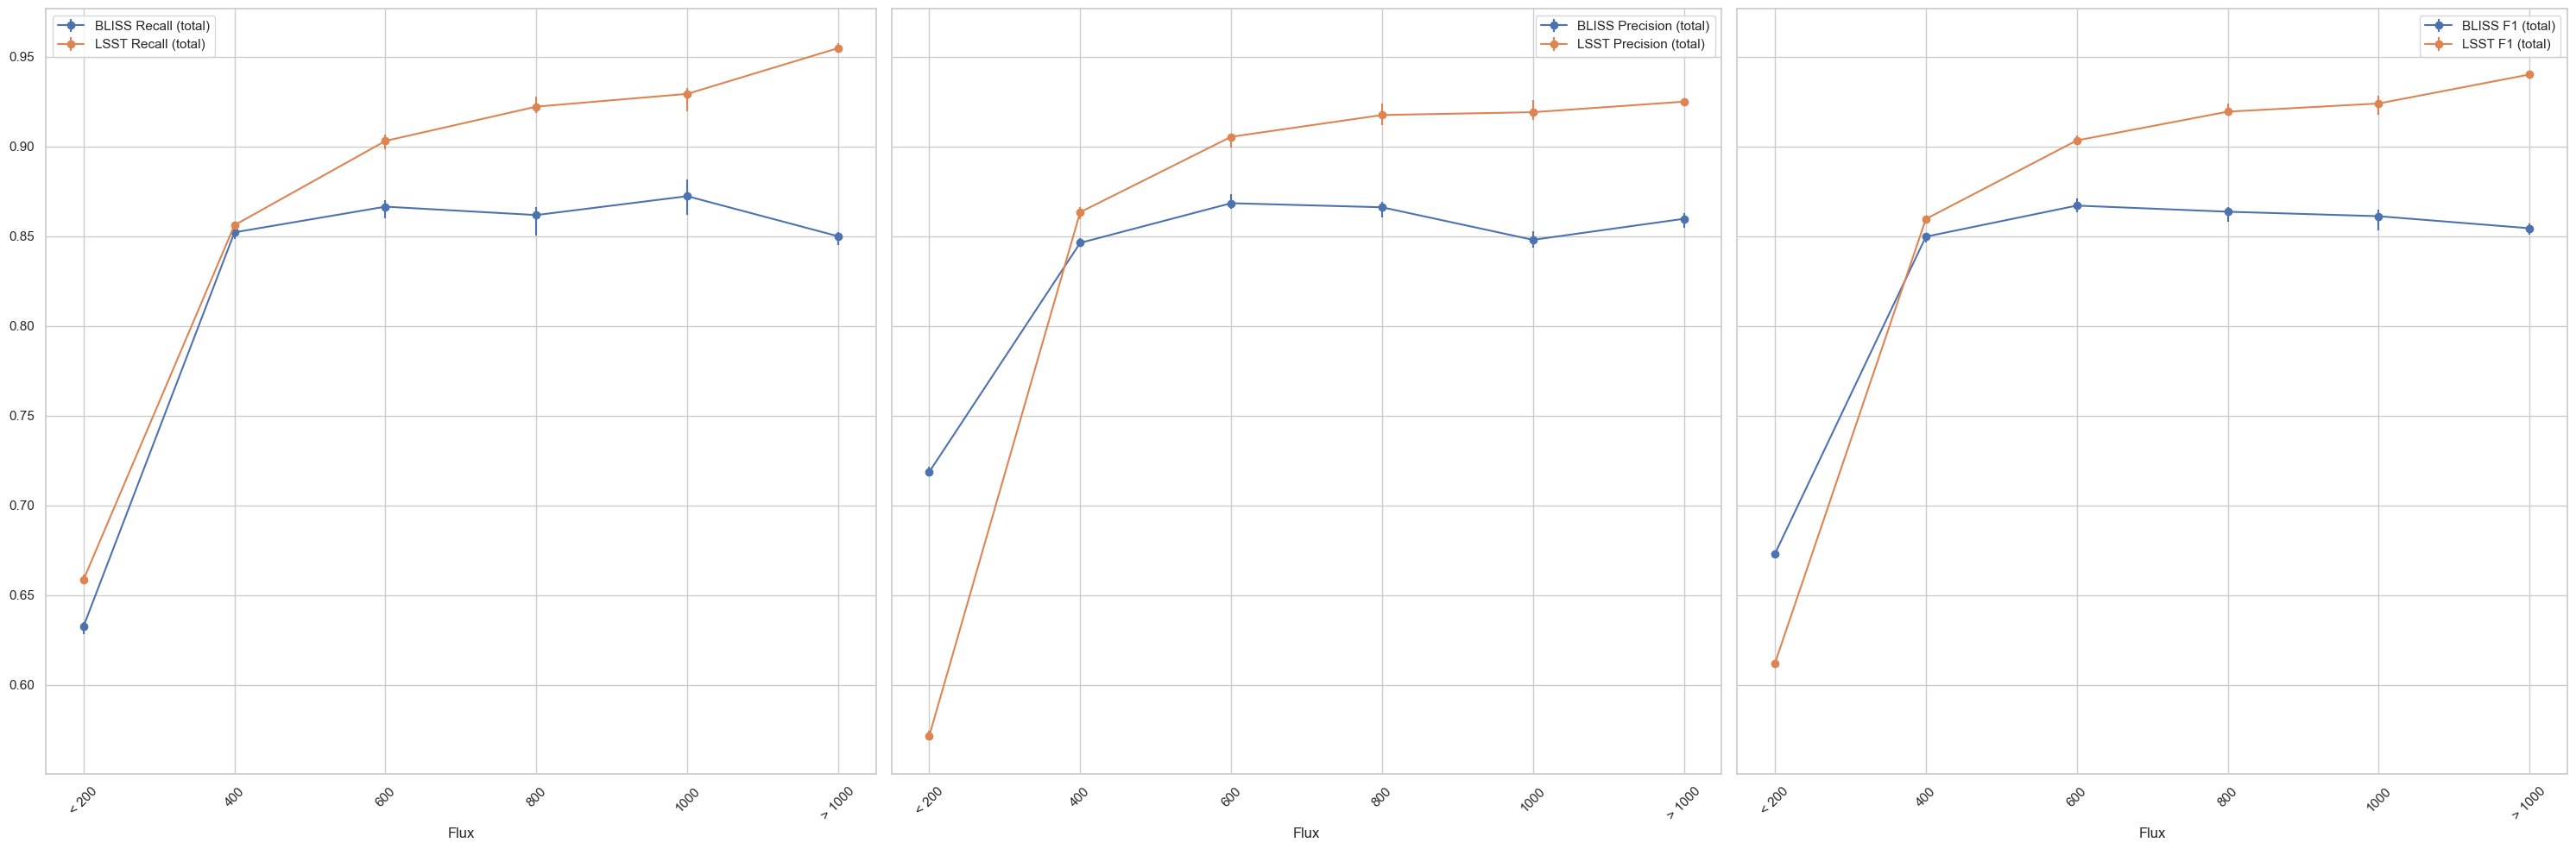

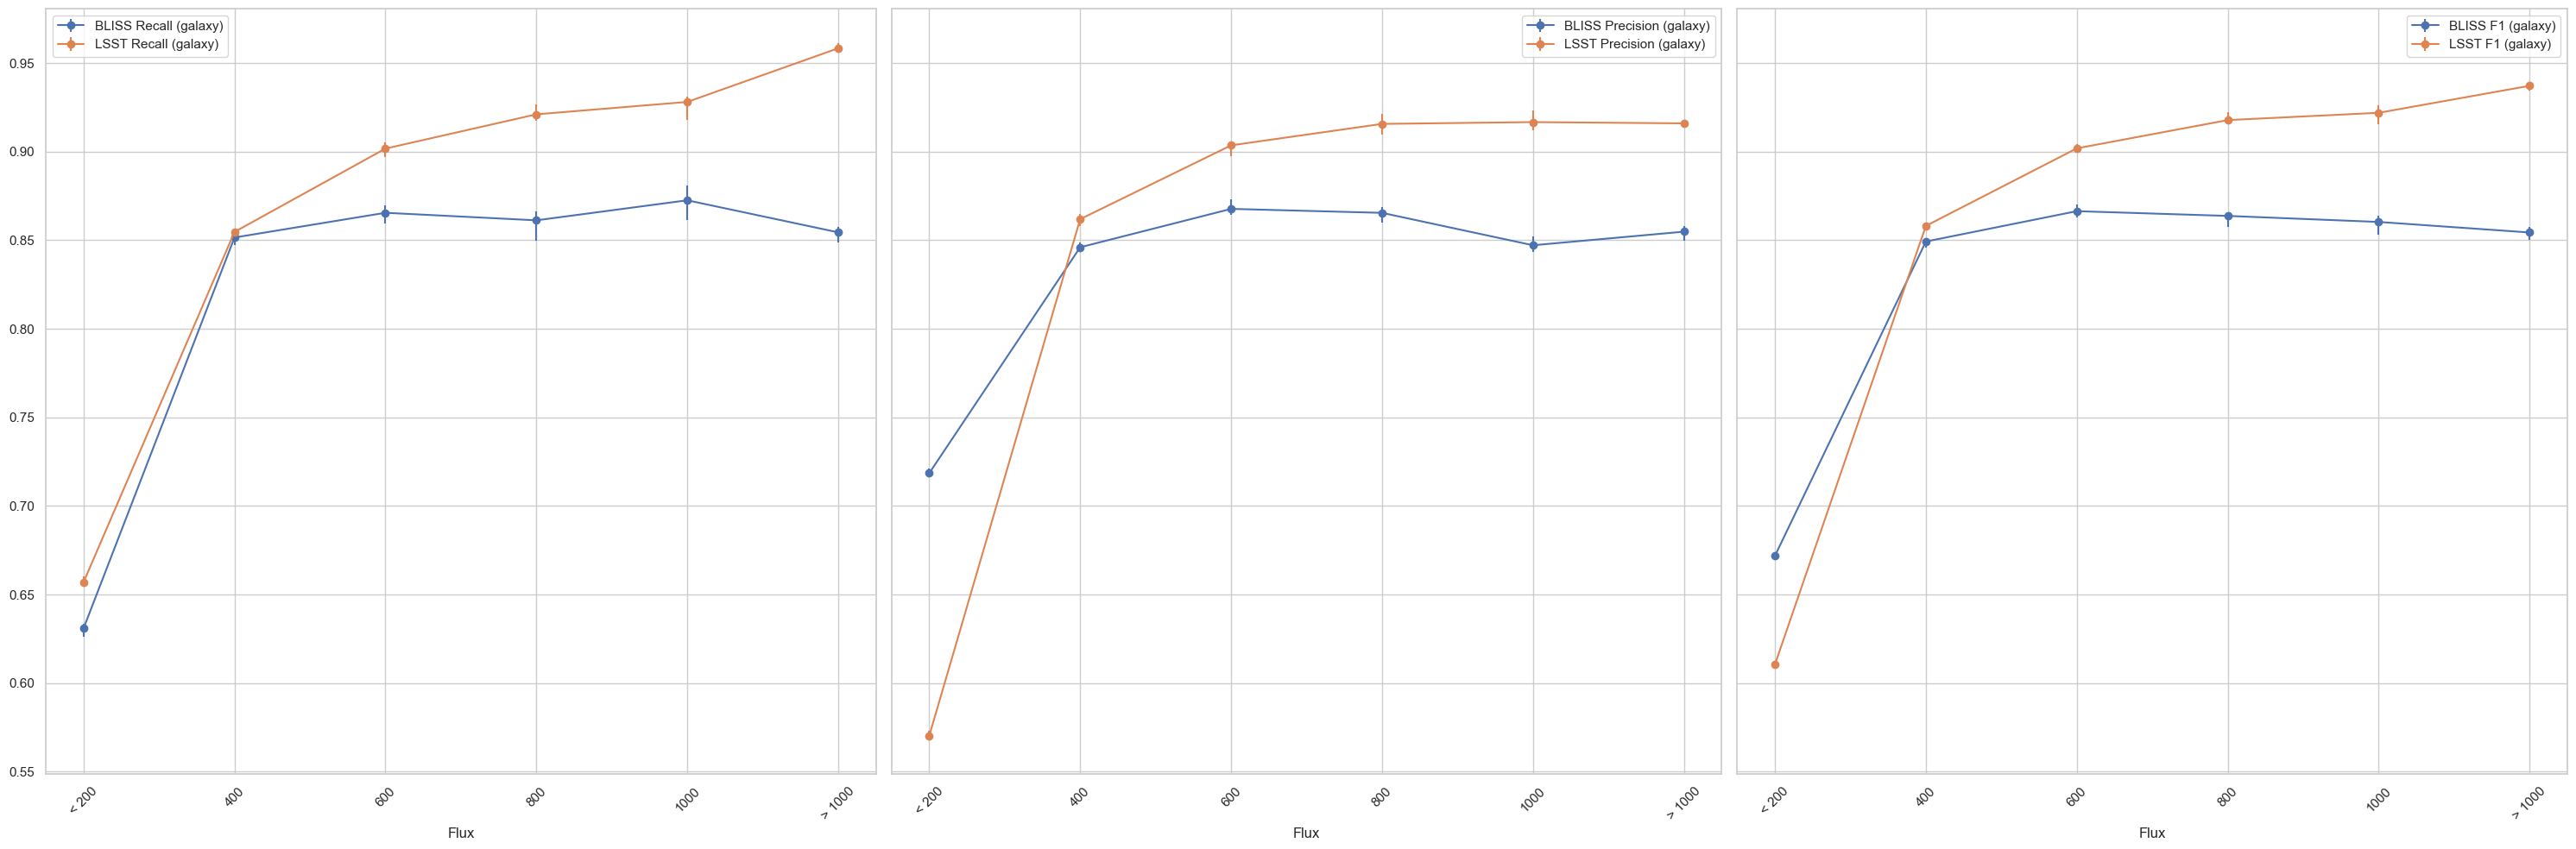

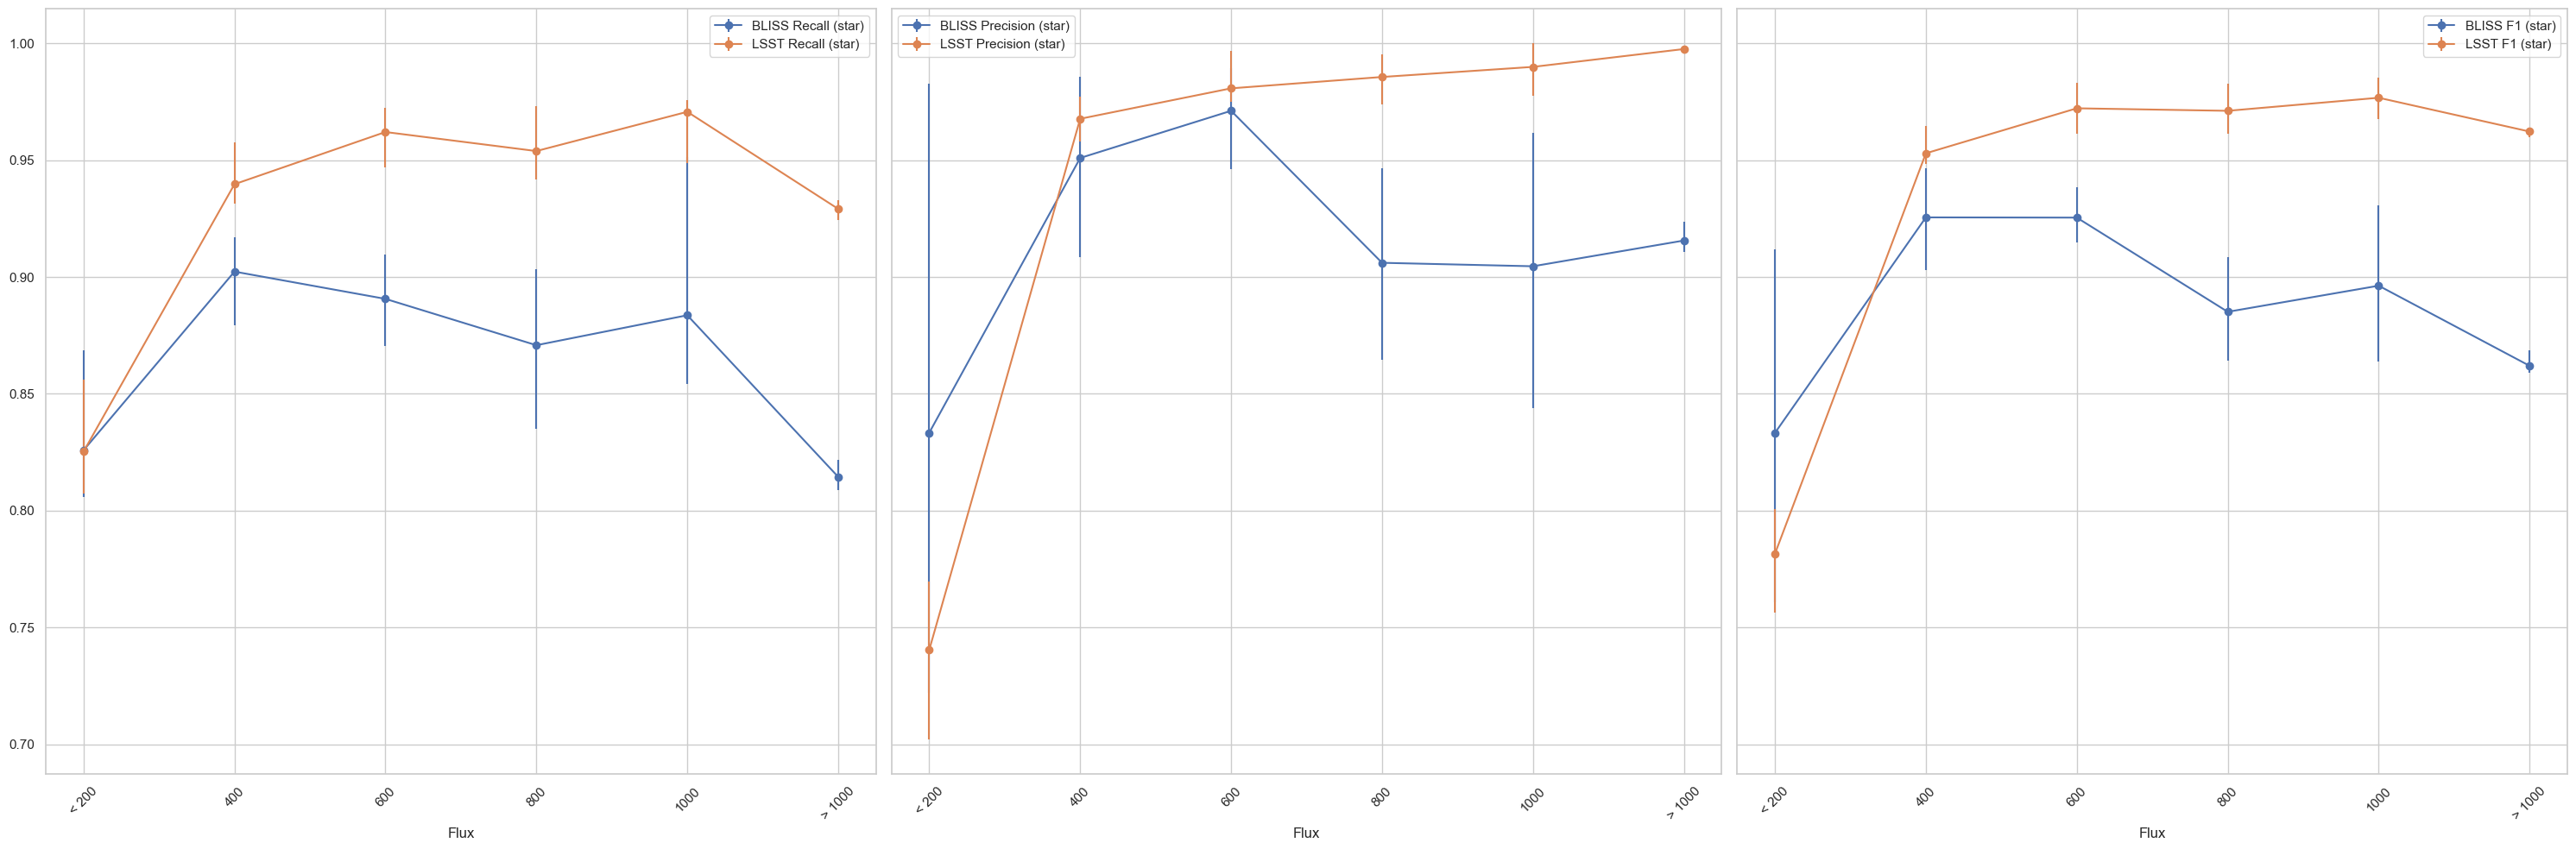

In [13]:
for k, v in bliss_metrics.items():
    if k == "detection_performance":
        fig, axes = plot_with_error_bars(bliss_results["detection_recall"],
                                        bliss_results["detection_precision"],
                                        bliss_results["detection_f1"],
                                        lsst_results["detection_recall"],
                                        lsst_results["detection_precision"],
                                        lsst_results["detection_f1"],
                                        mag_bin_cutoffs=v.mag_bin_cutoffs,
                                        exclude_last_bin=v.exclude_last_bin,
                                        bin_unit_is_flux=v.bin_unit_is_flux,
                                        source_type_name=v.source_type_name,
                                        model_name_1="BLISS",
                                        model_name_2="LSST")
    elif k == "detection_performance_star":
        fig, axes = plot_with_error_bars(bliss_results["detection_recall_star"],
                                        bliss_results["detection_precision_star"],
                                        bliss_results["detection_f1_star"],
                                        lsst_results["detection_recall_star"],
                                        lsst_results["detection_precision_star"],
                                        lsst_results["detection_f1_star"],
                                        mag_bin_cutoffs=v.mag_bin_cutoffs,
                                        exclude_last_bin=v.exclude_last_bin,
                                        bin_unit_is_flux=v.bin_unit_is_flux,
                                        source_type_name=v.source_type_name,
                                        model_name_1="BLISS",
                                        model_name_2="LSST")
    elif k == "detection_performance_galaxy":
        fig, axes = plot_with_error_bars(bliss_results["detection_recall_galaxy"],
                                        bliss_results["detection_precision_galaxy"],
                                        bliss_results["detection_f1_galaxy"],
                                        lsst_results["detection_recall_galaxy"],
                                        lsst_results["detection_precision_galaxy"],
                                        lsst_results["detection_f1_galaxy"],
                                        mag_bin_cutoffs=v.mag_bin_cutoffs,
                                        exclude_last_bin=v.exclude_last_bin,
                                        bin_unit_is_flux=v.bin_unit_is_flux,
                                        source_type_name=v.source_type_name,
                                        model_name_1="BLISS",
                                        model_name_2="LSST")
    else:
        raise NotImplementedError()
    
    fig.show()